In [11]:
from ozclim import tools
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
from scipy import stats 
import xarray as xr 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Open MDA8 O3 output for all three climate scenarios 

# Present-day
ref = tools.get_ensemble_ds("ref", "MDA8_O3")*1e9 # ppbv
refSNOx = tools.get_ensemble_ds("refSNOx", "MDA8_O3")*1e9 # ppbv

# Future-high
refshort = tools.get_ensemble_ds("refshort", "MDA8_O3")*1e9 # ppbv
refSNOxshort = tools.get_ensemble_ds("refSNOxshort", "MDA8_O3")*1e9 # ppbv

# Future-low
polshort = tools.get_ensemble_ds("pol3.7short", "MDA8_O3")*1e9 # ppbv
polSNOxshort = tools.get_ensemble_ds("pol3.7SNOxshort", "MDA8_O3")*1e9 # ppbv

['/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w10_ref_c48.MDA8_O3.nc4']
['/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w13_ref_c48.MDA8_O3.nc4']
['/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w14_ref_c48.MDA8_O3.nc4']
['/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w26_ref_c48.MDA8_O3.nc4']
['/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w28_ref_c48.MDA8_O3.nc4']
['/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w10_refSNOx_c48.MDA8_O3.nc4']
['/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w13_refSNOx_c48.MDA8_O3.nc4']
['/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w14_refSNOx_c48.MDA8_O3.nc4']
['/home/eleroy/proj-dirs/OZCLIM/data/analysis_data/GCHP_CAM_c48_20240312/GCHP.w26_refSNOx_c48.MDA8_O3.nc4']
['/home/eleroy/proj-dirs/OZCLIM/data/analysis_da

In [4]:
# Define the relative ratio: (Base-LNOx) / (Base)
present_ratio = refSNOx/ref
future_ratio = refSNOxshort/refshort
futurepol_ratio = polSNOxshort/polshort

present_ratio_noland = tools.mask_ocean_c48(present_ratio)
future_ratio_noland = tools.mask_ocean_c48(future_ratio)
futurepol_ratio_noland = tools.mask_ocean_c48(futurepol_ratio)

In [5]:
def get_days_per_month(region_num, month, present_ratio_noland, future_ratio_noland):

    # Select output from selected months
    present_ratio_noland = present_ratio_noland.sel(time=present_ratio_noland.time.dt.month.isin(month))
    future_ratio_noland = future_ratio_noland.sel(time=future_ratio_noland.time.dt.month.isin(month))

    present_ratio_noland_region = tools.crop_regionmask_ar6_c48(present_ratio_noland, region_num)
    future_ratio_noland_region = tools.crop_regionmask_ar6_c48(future_ratio_noland, region_num) 

    present = present_ratio_noland_region['SpeciesConc_O3'].isel(lev=0, region=0, drop=True)
    future = future_ratio_noland_region['SpeciesConc_O3'].isel(lev=0, region=0, drop=True)

    present_NDD_annual = present.where(present > 1).resample(time='1Y').count(dim=['time','Ydim','Xdim', 'nf'])
    future_NDD_annual = future.where(future > 1).resample(time='1Y').count(dim=['time','Ydim','Xdim', 'nf'])

    p = present_NDD_annual.values.flatten() # present
    f = future_NDD_annual.values.flatten() # future-high

    # Remove nans (means from seasons other than selected above will be nan)
    p = p[~np.isnan(p)]
    f = f[~np.isnan(f)]

    return p, f

In [6]:
region_num = 5
ENA_7p, ENA_7f = get_days_per_month(region_num, 7, present_ratio_noland, future_ratio_noland)
ENA_12p, ENA_12f = get_days_per_month(region_num, 12, present_ratio_noland, future_ratio_noland)

region_num = 17
WCE_7p, WCE_7f = get_days_per_month(region_num, 7, present_ratio_noland, future_ratio_noland)
WCE_12p, WCE_12f = get_days_per_month(region_num, 12, present_ratio_noland, future_ratio_noland)

region_num = 35
EAS_7p, EAS_7f = get_days_per_month(region_num, 7, present_ratio_noland, future_ratio_noland)
EAS_12p, EAS_12f = get_days_per_month(region_num, 12, present_ratio_noland, future_ratio_noland)

In [7]:
print(np.round(np.mean(ENA_12p),0))
print(np.round(np.std(ENA_12p),0))
print(np.round(np.mean(ENA_12f),0))
print(np.round(np.std(ENA_12f),0))


1034.0
257.0
1279.0
200.0


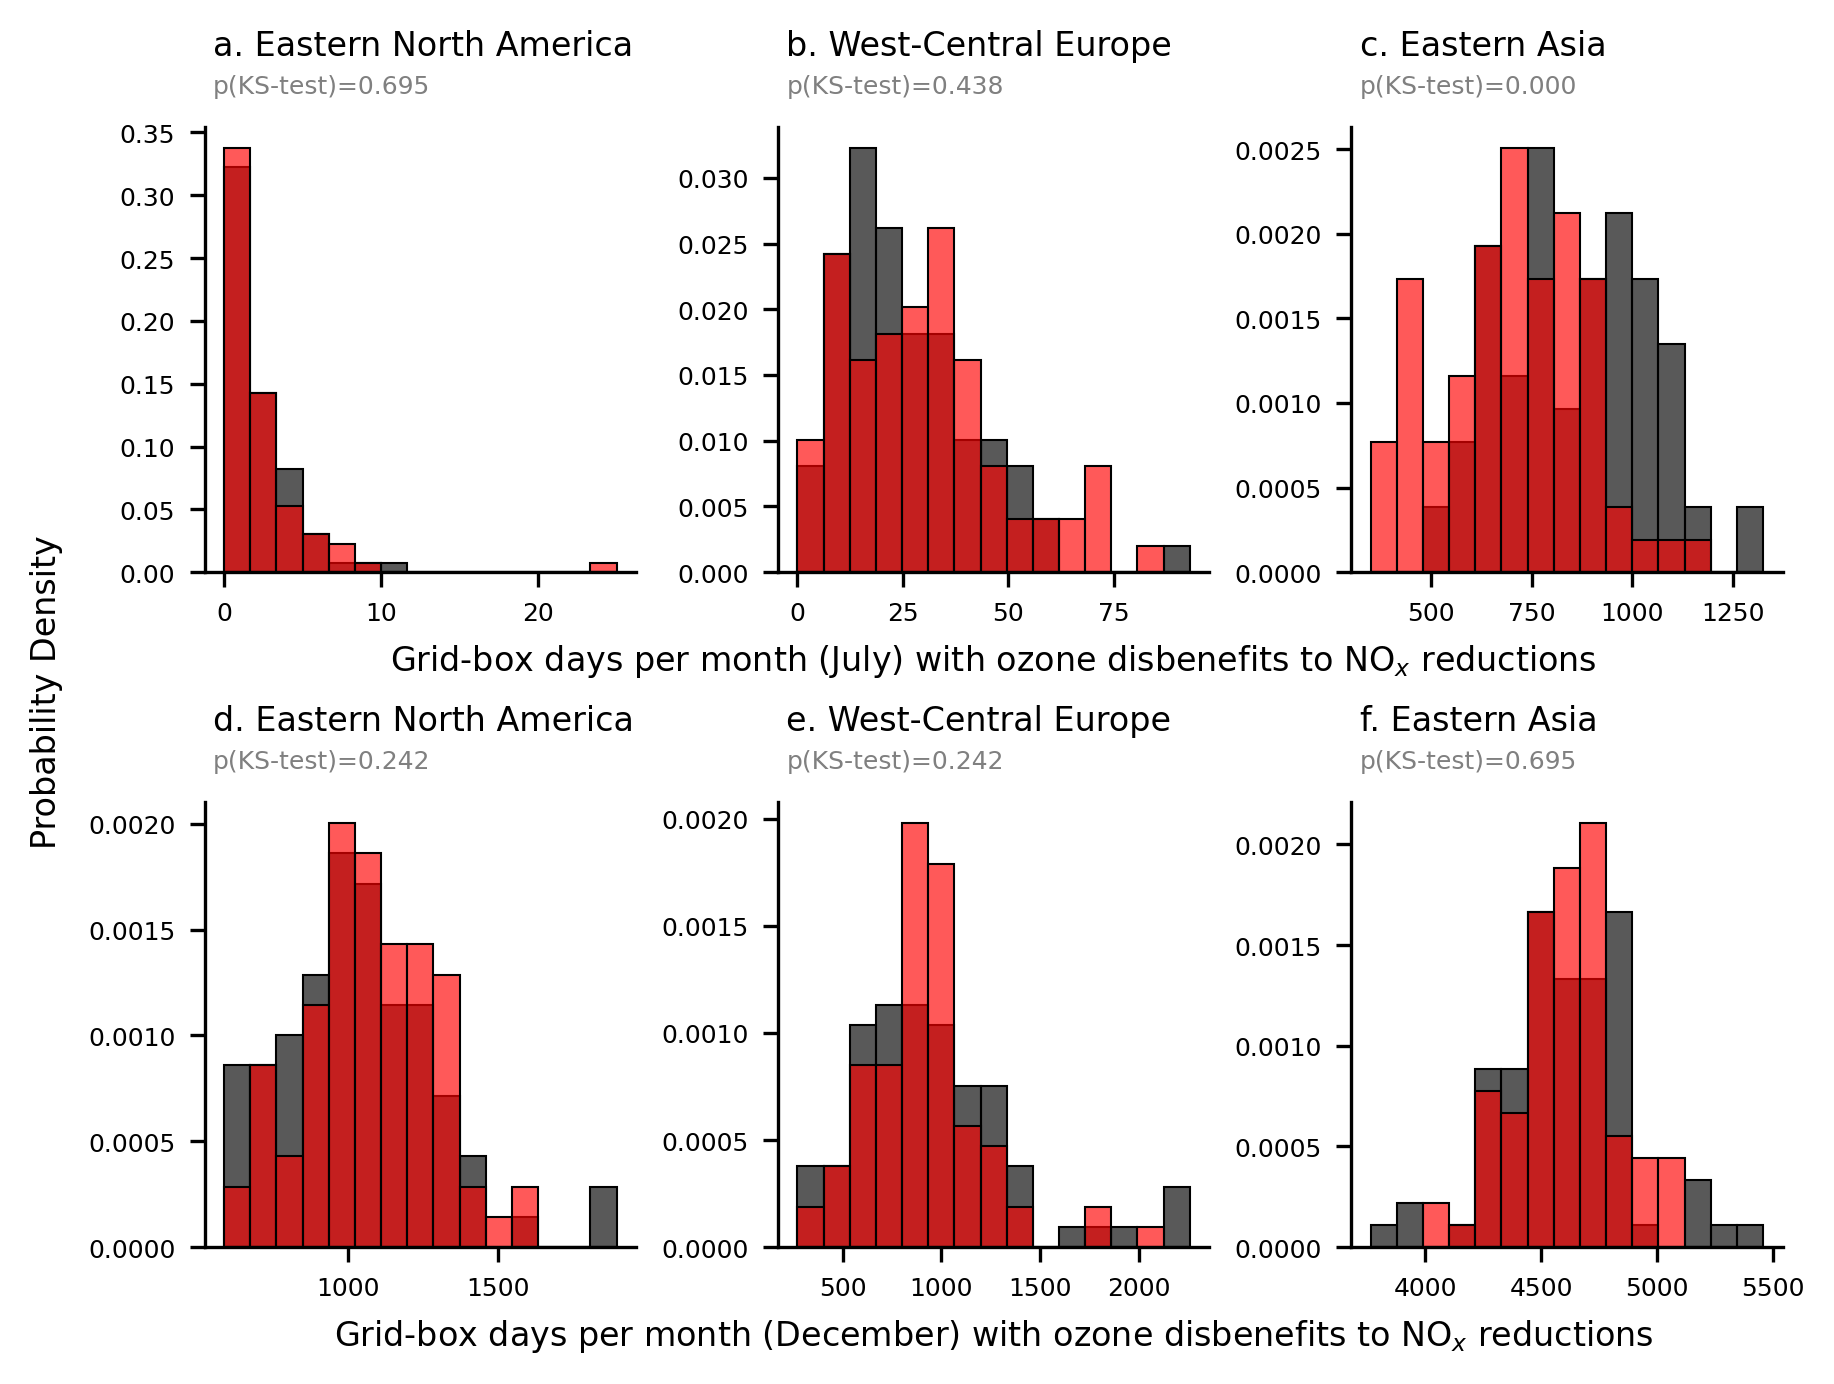

In [16]:


def plot_histogram(ax, data1, data2, num_bins, title, color2):
    """
    Helper function to plot histograms and calculate KS-test p-value.
    """
    min_val = min(np.concatenate([data1]).min(), np.concatenate([data2]).min())
    max_val = max(np.concatenate([data1]).max(), np.concatenate([data2]).max())
    
    sns.histplot(data1, bins=num_bins, binrange=[min_val, max_val],
                 stat="density", ax=ax, kde=False, color='black',
                 edgecolor="k", linewidth=0.5, alpha=0.65)
    sns.histplot(data2, bins=num_bins, binrange=[min_val, max_val],
                 stat="density", ax=ax, kde=False, color=color2,
                 edgecolor="k", linewidth=0.5, alpha=0.65)
    
    # KS-test
    _, pval_ks = stats.ks_2samp(data1, data2)
    formatted_pval_ks = format(pval_ks, ".3f")
    ax.text(.02, 1.12, f"p(KS-test)={formatted_pval_ks}", ha='left', va='top',
            transform=ax.transAxes, color='grey', fontsize=6)
    ax.text(.02, 1.22, title, ha='left', va='top', transform=ax.transAxes, color='black', fontsize=8)

fig, ax = plt.subplots(
    figsize=(6, 4.5),  
    dpi=300,         
    nrows=2, ncols=3,
    constrained_layout=True,
)
ax = ax.flatten()

titles = [
    "a. Eastern North America", "b. West-Central Europe", "c. Eastern Asia",
    "d. Eastern North America", "e. West-Central Europe", "f. Eastern Asia"
]
datasets = [
    (ENA_7p, ENA_7f, "red"), 
    (WCE_7p, WCE_7f, "red"), 
    (EAS_7p, EAS_7f, "red"), 
    (ENA_12p, ENA_12f, "red"), 
    (WCE_12p, WCE_12f, "red"), 
    (EAS_12p, EAS_12f, "red"), 
]

num_bins = 15
for i, (data1, data2, color2) in enumerate(datasets):
    plot_histogram(ax[i], data1, data2, num_bins, titles[i], color2)

for axis in ax:
    axis.spines[['right', 'top']].set_visible(False)
    axis.set_ylabel(None)
    axis.tick_params(axis='both', labelsize=6)  # Adjust tick label size

ax[1].set_xlabel("Grid-box days per month (July) with ozone disbenefits to NO$_x$ reductions", fontsize=8)
ax[4].set_xlabel("Grid-box days per month (December) with ozone disbenefits to NO$_x$ reductions", fontsize=8)

ylabel = "Probability Density"
fig.supylabel(ylabel, fontsize=8)  # Set global ylabel

plt.savefig("Fig3.pdf")


In [9]:
region_num = 5
ENA_7p, ENA_7f = get_days_per_month(region_num, 7, present_ratio_noland, futurepol_ratio_noland)
ENA_12p, ENA_12f = get_days_per_month(region_num, 12, present_ratio_noland, futurepol_ratio_noland)

region_num = 17
WCE_7p, WCE_7f = get_days_per_month(region_num, 7, present_ratio_noland, futurepol_ratio_noland)
WCE_12p, WCE_12f = get_days_per_month(region_num, 12, present_ratio_noland, futurepol_ratio_noland)

region_num = 35
EAS_7p, EAS_7f = get_days_per_month(region_num, 7, present_ratio_noland, futurepol_ratio_noland)
EAS_12p, EAS_12f = get_days_per_month(region_num, 12, present_ratio_noland, futurepol_ratio_noland)

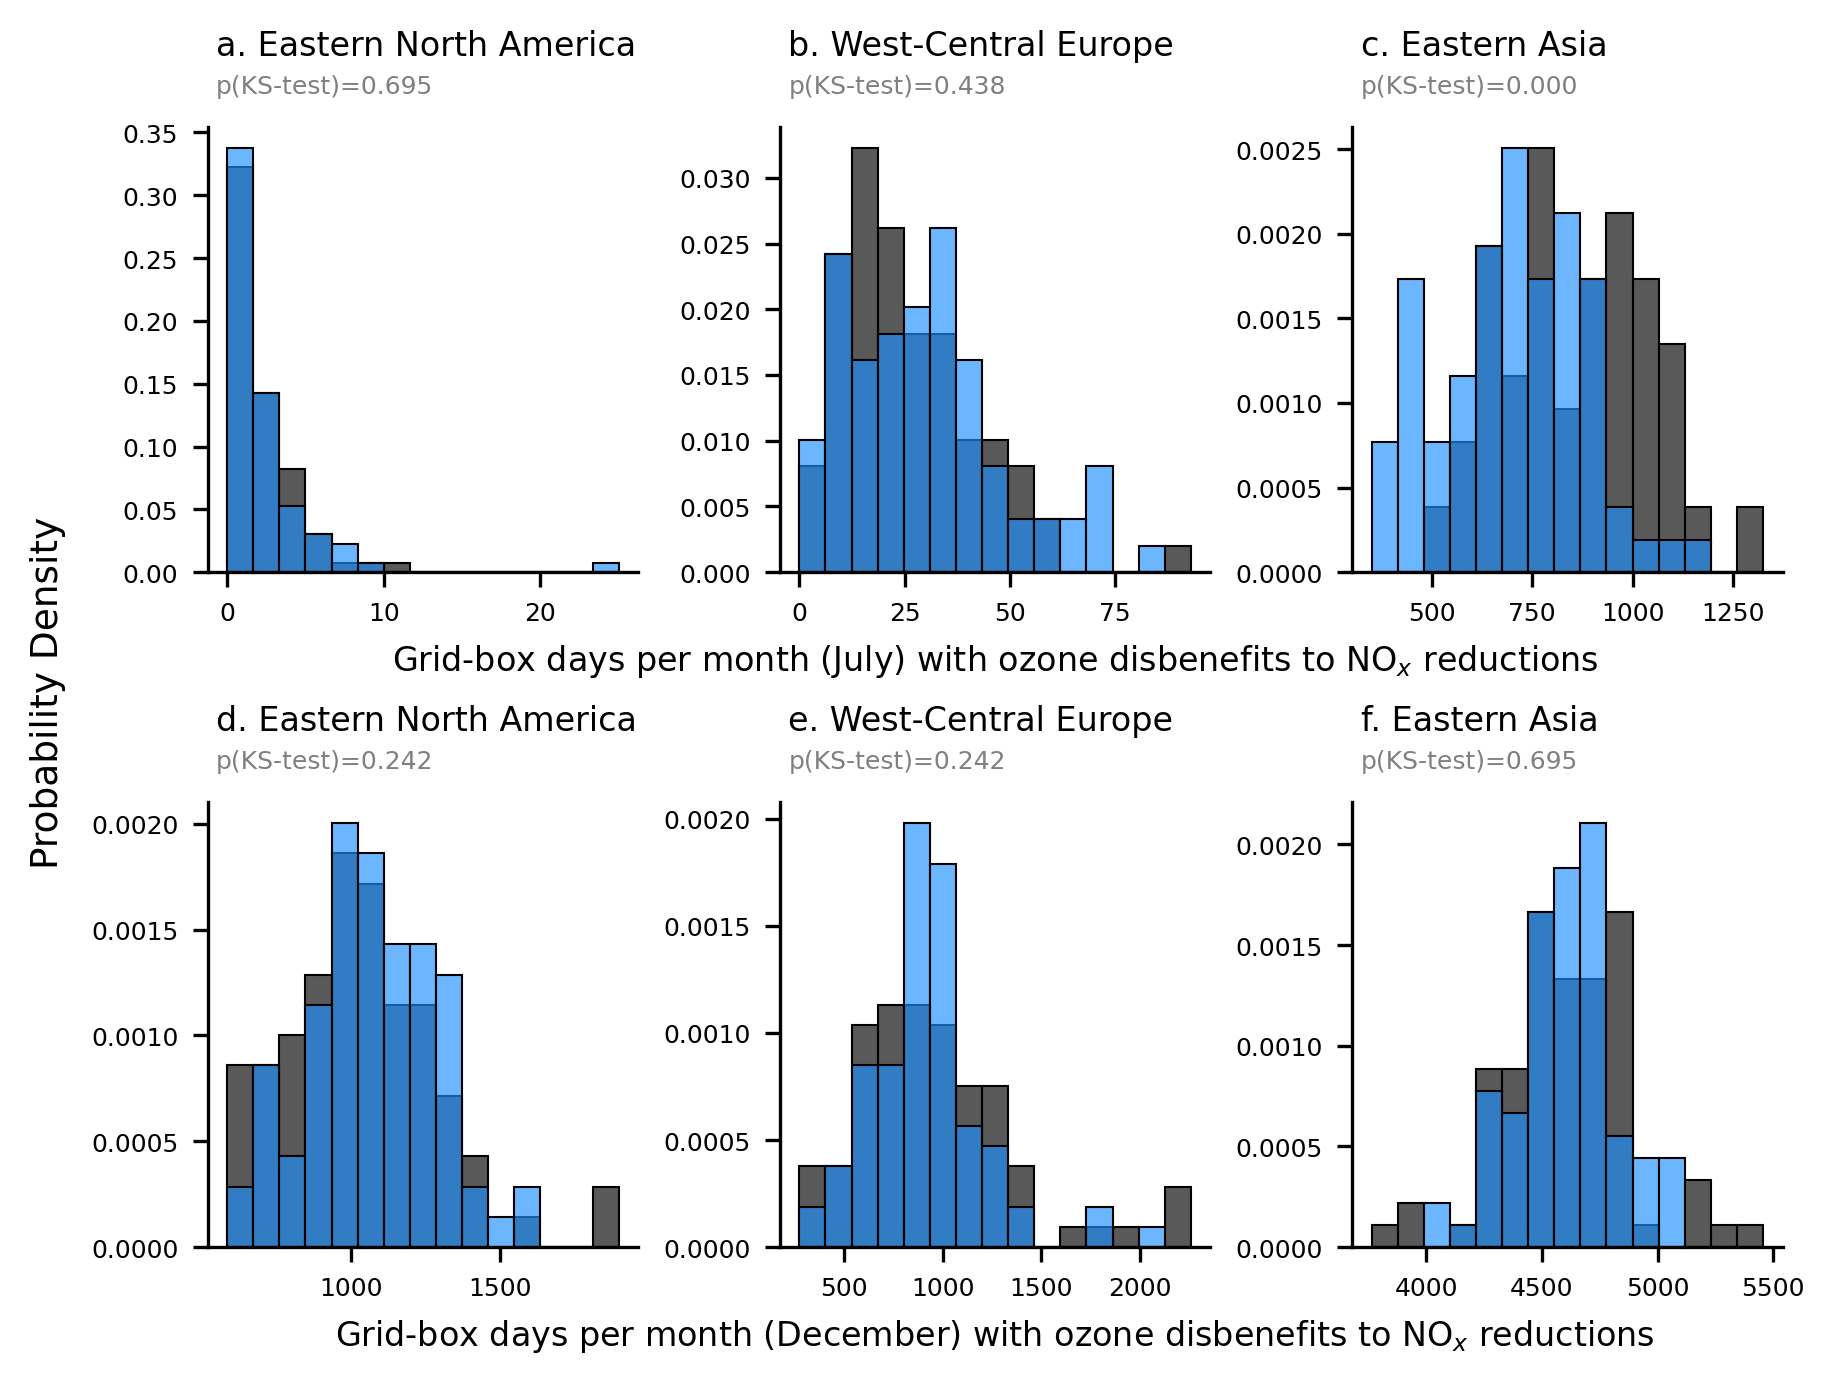

In [17]:

def plot_histogram(ax, data1, data2, num_bins, title, color2):
    """
    Helper function to plot histograms and calculate KS-test p-value.
    """
    min_val = min(np.concatenate([data1]).min(), np.concatenate([data2]).min())
    max_val = max(np.concatenate([data1]).max(), np.concatenate([data2]).max())
    
    sns.histplot(data1, bins=num_bins, binrange=[min_val, max_val],
                 stat="density", ax=ax, kde=False, color='black',
                 edgecolor="k", linewidth=0.5, alpha=0.65)
    sns.histplot(data2, bins=num_bins, binrange=[min_val, max_val],
                 stat="density", ax=ax, kde=False, color=color2,
                 edgecolor="k", linewidth=0.5, alpha=0.65)
    
    # KS-test
    _, pval_ks = stats.ks_2samp(data1, data2)
    formatted_pval_ks = format(pval_ks, ".3f")
    ax.text(.02, 1.12, f"p(KS-test)={formatted_pval_ks}", ha='left', va='top',
            transform=ax.transAxes, color='grey', fontsize=6)
    ax.text(.02, 1.22, title, ha='left', va='top', transform=ax.transAxes, color='black', fontsize=8)

fig, ax = plt.subplots(
    figsize=(6, 4.5),  
    dpi=300,         
    nrows=2, ncols=3,
    constrained_layout=True,
)
ax = ax.flatten()

titles = [
    "a. Eastern North America", "b. West-Central Europe", "c. Eastern Asia",
    "d. Eastern North America", "e. West-Central Europe", "f. Eastern Asia"
]
datasets = [
    (ENA_7p, ENA_7f, "dodgerblue"), 
    (WCE_7p, WCE_7f, "dodgerblue"), 
    (EAS_7p, EAS_7f, "dodgerblue"), 
    (ENA_12p, ENA_12f, "dodgerblue"), 
    (WCE_12p, WCE_12f, "dodgerblue"), 
    (EAS_12p, EAS_12f, "dodgerblue"), 
]

num_bins = 15
for i, (data1, data2, color2) in enumerate(datasets):
    plot_histogram(ax[i], data1, data2, num_bins, titles[i], color2)

for axis in ax:
    axis.spines[['right', 'top']].set_visible(False)
    axis.set_ylabel(None)
    axis.tick_params(axis='both', labelsize=6)  # Adjust tick label size

ax[1].set_xlabel("Grid-box days per month (July) with ozone disbenefits to NO$_x$ reductions", fontsize=8)
ax[4].set_xlabel("Grid-box days per month (December) with ozone disbenefits to NO$_x$ reductions", fontsize=8)

ylabel = "Probability Density"
fig.supylabel(ylabel, fontsize=9)  # Set global ylabel

#fig.tight_layout(pad=0.3, w_pad=0.5, h_pad=0.5)

plt.savefig("FigS7.pdf")
